## 1. package import 

In [4]:
# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol
# Import date and time zone libraries
from datetime import datetime
import pandas as pd
import warnings

import pytz

# Import visualization
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = "ggplot2"

warnings.filterwarnings('ignore')

## 2. func

### `initialize`
- 거래하려는 주식과 사용하려는 이동 평균 윈도우를 설정한다.

### `handle_data`
- 새로운 데이터 포인트 각각에 대해 실행된다.
- 여기서는 일일 데이터를 사용하므로 하루에 한번 호출 된다.
- 가장 먼저 시계열 히스토리를 가져온다.
- 함수 정의에서 전달된 data 객체를 통해 history 메서드를 사용할 수 있다.  
  ( `context.stock`를 통해 한 개가 아닌 다수의 주식 리스트를 입력할 수도 있다.)  
- `history`에 대한 두 번째 인수로 모델에서 필요한  `close` 문자열을 입력한다.   
    여기서 ['open', 'high','low','close']와 같은 문자열 리스트 사용도 가능한다.  
- `history`에 원하는 데이터 포인트 수를 지정한다. `context.index_average_window` 저장되어 있다.  
- `history`에 빈도를 입력한다. 여기서는 `1d`이다.

- `order_target_percent`는 주문을 비율로 지정한다.; `order_target`은 원하는 주식 수를 지정할 수 있다.

### `analyze`
- 백테스트가 모두 완료된 후 호출되며, 여기서 분석을 계산하고 시각화 할 수 있다.

- 예시의 트레이딩 논리: 가격이 이동 평균 위이면 롱을 취하고, 그렇지 않으면 포지션을 취하지 않는다.

In [5]:
def initialize(context):
    # 거래할 주식 지정
    context.stock = symbol('AAPL')
    # 이동 평균 윈도우
    context.index_average_window = 100
    
def handle_data(context, data):
    # Request history for the stock
    equities_hist = data.history(context.stock, "close", 
                                 context.index_average_window, "1d")
    
    # 트레이딩 논리
    if equities_hist[-1] > equities_hist.mean(): stock_weight = 1.0  # 마지막 가격이 평균보다 위이면 매수 
    else:stock_weight = 0.0

    # Place order
    order_target_percent(context.stock, stock_weight)

def analyze(context, perf):
    legendStyle=dict(orientation="h",yanchor="bottom", y=1.02,xanchor="right",x=1)
    lineStyle_01=dict(width=1.0)
    lineStyle_03=dict(width=1.0)
    
    fig = make_subplots(rows=3, cols=1)
    fig.add_trace(go.Scatter(x=perf.index, y=perf['portfolio_value'], mode="lines", name="Equity Curve", line=lineStyle_03),  row=1, col=1)
    fig.add_trace(go.Scatter(x=perf.index, y=perf['gross_leverage'],  mode="lines", name="Exposure", line=lineStyle_01), row=2, col=1)
    fig.add_trace(go.Scatter(x=perf.index, y=perf['returns'],  mode="lines", name="Returns", line=lineStyle_01), row=3, col=1)
    
    fig.update_xaxes(showgrid=False, row=1, col=1)
    fig.update_layout(height=1200, width=800, title="Strategy Results", legend=legendStyle)
    fig.show()

## 3. Run

- 첫번 째는 포트폴리오 가치 변화를 보여준다. 
- 두번 째는 `gross_leverage`는 시장 노출도 이다.
- 세번 째는 일일 퍼센트 수익률이다.

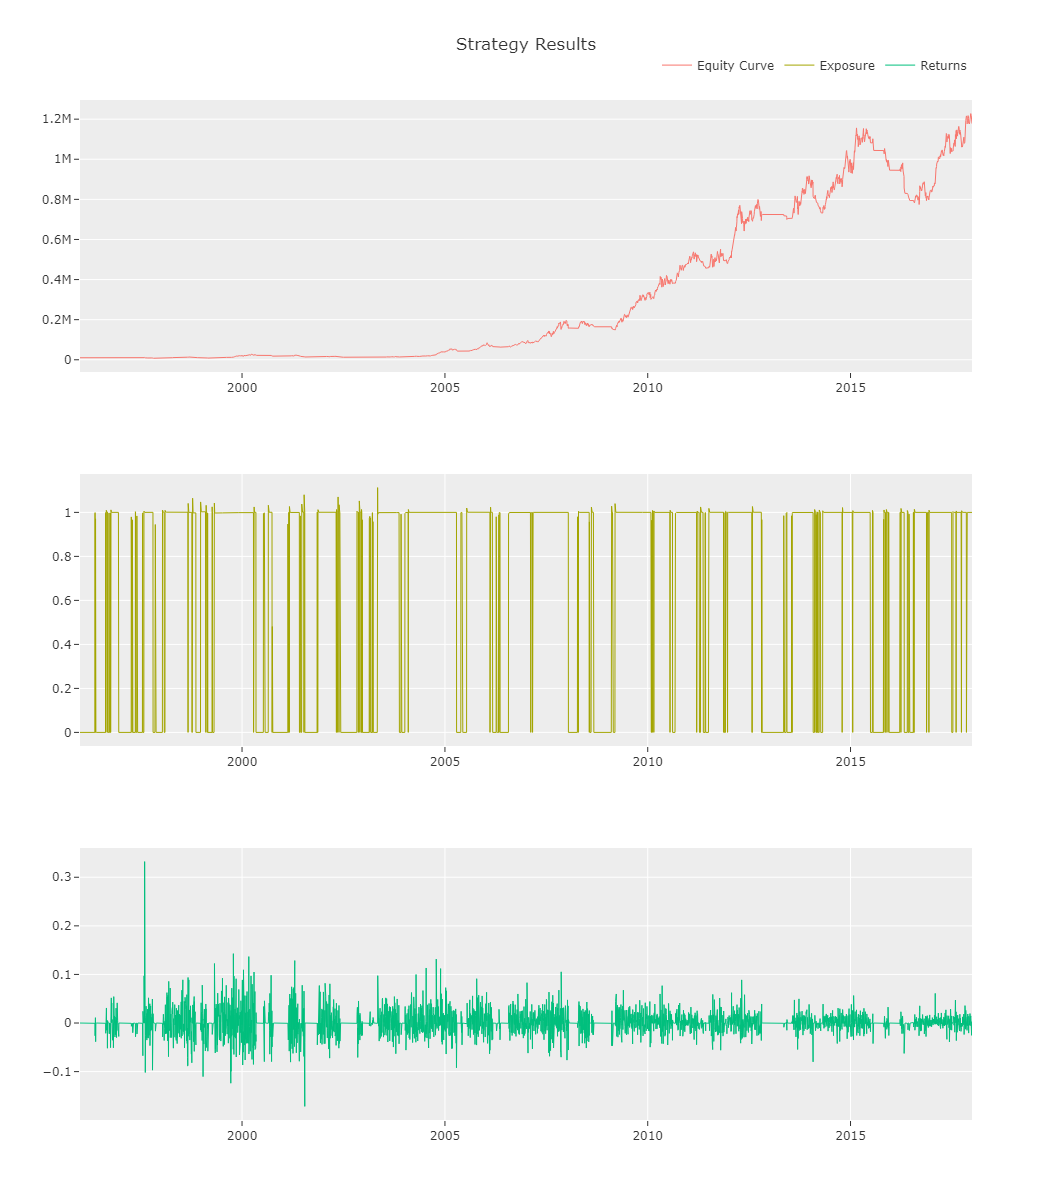

In [12]:
# Set start and end date
# start_date = datetime(1996, 1, 1, tzinfo=pytz.UTC)
# end_date = datetime(2018, 12, 31, tzinfo=pytz.UTC)
start_date = pd.Timestamp('1996-1-1')
end_date = pd.Timestamp('2017-12-31')

# Fire off the backtest
results = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize, 
    analyze=analyze, 
    handle_data=handle_data, 
    capital_base=10000, 
    data_frequency = 'daily', bundle='quandl' 
) 


---